### learnings

- Never test on the oversampled or undersampled dataset

- If we want to implement cross validation, remember to oversample or undersample your
training data during cross-validation, not before!

- Don't use accuracy score as a metric with imbalanced datasets (will be usually high and misleading),
instead use f1-score, precision/recall score, or Precision-Recall Curve (AUPRC)

- There are variables from PCA, the original variables must be scaled before applying PCA

### imports

In [64]:
import kagglehub
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
from dotenv import load_dotenv

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

# Metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
import warnings
warnings.filterwarnings("ignore")

load_dotenv()

True

### download the dataset

In [2]:
# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print(f"Dataset downloaded to: {path}")

100%|██████████| 66.0M/66.0M [00:02<00:00, 31.6MB/s]

Extracting files...


Dataset downloaded to: /home/yezer/projects/credit-fraud-detector/datasets/datasets/mlg-ulb/creditcardfraud/versions/3


### explore the dataset


In [60]:
df = pd.read_csv(f"{path}/creditcard.csv")
print("df.shape", df.shape)
df.head()

df.shape (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [23]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [51]:
print(f"- total null values:{df.isnull().sum().sum()}")
print(f"- % null values:{df.isnull().sum().sum()*100/df.notnull().sum().sum()}")
print(f"- 99% of transactions are under ${df['Amount'].quantile(0.99):.2f}")
print(f"\n- % fraud transactions:{100*df[df.Class==1].shape[0]/df.shape[0]:.2f}")
print(f"- fraud transactions with amount 0 -> {df[(df.Class==1) & (df.Amount==0.0)].shape[0]}")
print(f"- fraud transactions max amount -> {df[df.Class==1]['Amount'].max()}")
print(f"\n- % correct transactions:{100*df[df.Class==0].shape[0]/df.shape[0]:.2f}")
print(f"- correct transactions with amount 0 -> {df[(df.Class==0) & (df.Amount==0.0)].shape[0]}")
print(f"- correct transactions max amount -> {df[df.Class==0]['Amount'].max()}")


- total null values:0
- % null values:0.0
- 99% of transactions are under $1017.97

- % fraud transactions:0.17
- fraud transactions with amount 0 -> 27
- fraud transactions max amount -> 2125.87

- % correct transactions:99.83
- correct transactions with amount 0 -> 1798
- correct transactions max amount -> 25691.16


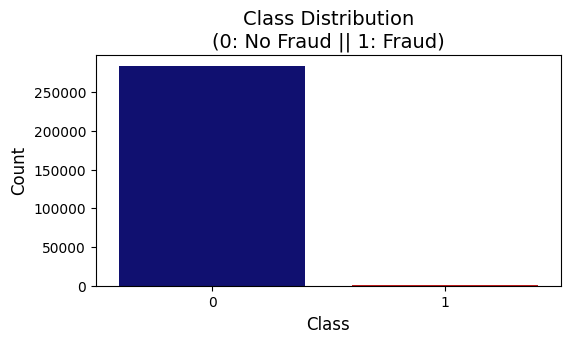

In [46]:
# Plot class distribution
plt.figure(figsize=(6, 3))
colors = ["#000080", "#DF0101"]  # Dark blue for non-fraud, Red for fraud
sns.countplot(x='Class', data=df, palette=colors)
plt.title('Class Distribution\n(0: No Fraud || 1: Fraud)', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


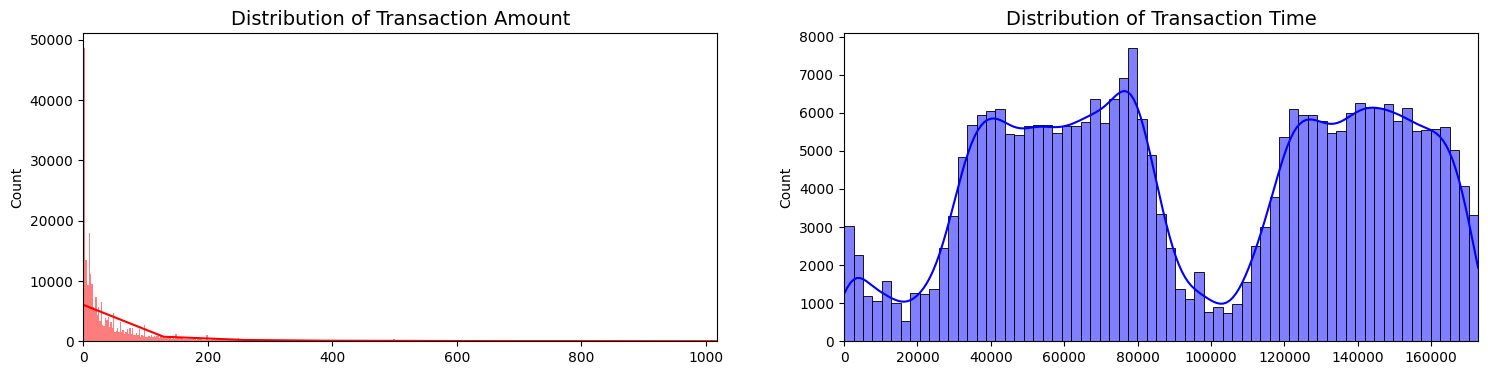

In [61]:
# Create figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(18,4))

# Get transaction amounts and times
amount_val = df['Amount'].values
time_val = df['Time'].values

# Plot distribution of transaction amounts
sns.histplot(amount_val, ax=ax[0], color='r', kde=True)
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), np.percentile(amount_val, 99)])  # Limit x-axis to 99th percentile

# Plot distribution of transaction times 
sns.histplot(time_val, ax=ax[1], color='b', kde=True)
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

### scaling

In this phase of our kernel, we will first scale the columns comprise of Time and Amount .
Time and amount should be scaled as the other columns

In [62]:
# RobustScaler is less prone to outliers.
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)
df.head()


,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


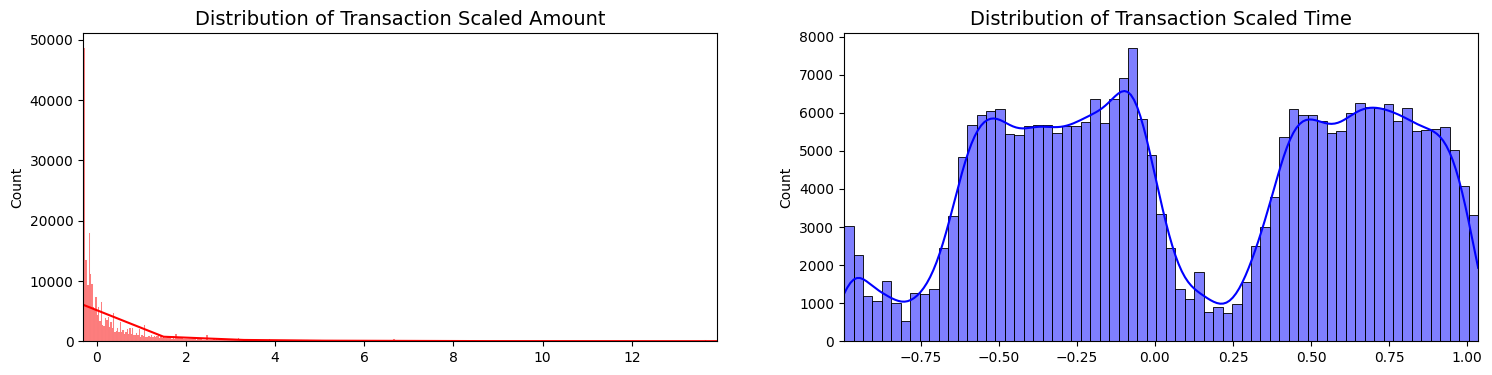

In [63]:
# Create figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(18,4))

# Get transaction amounts and times
amount_val = df['scaled_amount'].values
time_val = df['scaled_time'].values

# Plot distribution of transaction amounts
sns.histplot(amount_val, ax=ax[0], color='r', kde=True)
ax[0].set_title('Distribution of Transaction Scaled Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), np.percentile(amount_val, 99)])  # Limit x-axis to 99th percentile

# Plot distribution of transaction times 
sns.histplot(time_val, ax=ax[1], color='b', kde=True)
ax[1].set_title('Distribution of Transaction Scaled Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

### baseline model (AUPRC metric)

- Run Cross-Validation Across Multiple Seeds (For Robustness). Try several seeds and observe the distribution of metrics. This tells you how sensitive your model is to random splits. Cross-validation is primarily a technique to get a reliable estimate of how your model will perform on unseen data and to select the best model/hyperparameters. Once you've made that selection, you want your final model to learn from as much data as possible. Training on the full dataset allows the model to see all available examples, which can lead to a potentially more robust and slightly better-performing model.

- Use this to check stability across seeds rather than choosing a single “best” one.

- Once Satisfied, Fix One Seed for Reproducibility

- If the performance is not stable across seeds, your dataset may be:Too small or too noisy or extremely sensitive to the splits.

- What Does AUPRC Measure?
It quantifies the trade-off between:
Precision = How many of the predicted positives are actually positive
Recall = How many of the actual positives are correctly predicted
The Precision-Recall Curve shows this trade-off at all possible classification thresholds (e.g. values over 0.1 are fraud, 02, 0.3, ...). The area under that curve
(AUPRC) summarizes the model’s performance in one number.

- AUPRC is better for imbalanced datasets, however AUC-ROC is better for balanced ones. AUPRC focuses only on the positive class, so it tells you how well the model is identifying the rare events (e.g., hotel reservations in your case), which is what you care about most.

- AUPRC summarizes performance over all thresholds — to actually deploy a model, you still need to choose a specific threshold based on business trade-offs between precision and recall.

In [91]:
all_auprc_scores = []

X = df.drop('Class', axis=1)
y = df['Class']

for seed in [1, 7, 21, 42, 100, 123]:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    fold_auprcs = []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = LogisticRegression(random_state=seed)
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_val)[:, 1]

        auprc = average_precision_score(y_val, y_pred_proba)
        fold_auprcs.append(auprc)

    mean_auprc = np.mean(fold_auprcs)
    std_auprc = np.std(fold_auprcs)
    print(f'Seed {seed} - Mean AUPRC: {mean_auprc:.4f} std: {std_auprc:.4f}')
    all_auprc_scores.append((seed, mean_auprc))

Seed 1 - Mean AUPRC: 0.7543 std: 0.0375
Seed 7 - Mean AUPRC: 0.7580 std: 0.0511
Seed 21 - Mean AUPRC: 0.7598 std: 0.0095
Seed 42 - Mean AUPRC: 0.7563 std: 0.0226
Seed 100 - Mean AUPRC: 0.7567 std: 0.0495
Seed 123 - Mean AUPRC: 0.7559 std: 0.0243


In [92]:
# Generate Random Classifier Baseline
# Create random predictions and calculate AUPRC to compare with our model
random_preds = np.random.random(len(y))
random_auprc = average_precision_score(y, random_preds)
print(f'\nRandom Classifier AUPRC: {random_auprc:.4f}')


Random Classifier AUPRC: 0.0019


Fold 1 - AUPRC: 0.7175
Fold 2 - AUPRC: 0.7598
Fold 3 - AUPRC: 0.7775
Fold 4 - AUPRC: 0.7792
Fold 5 - AUPRC: 0.7478

Mean AUPRC: 0.7563 (+/- 0.0453)


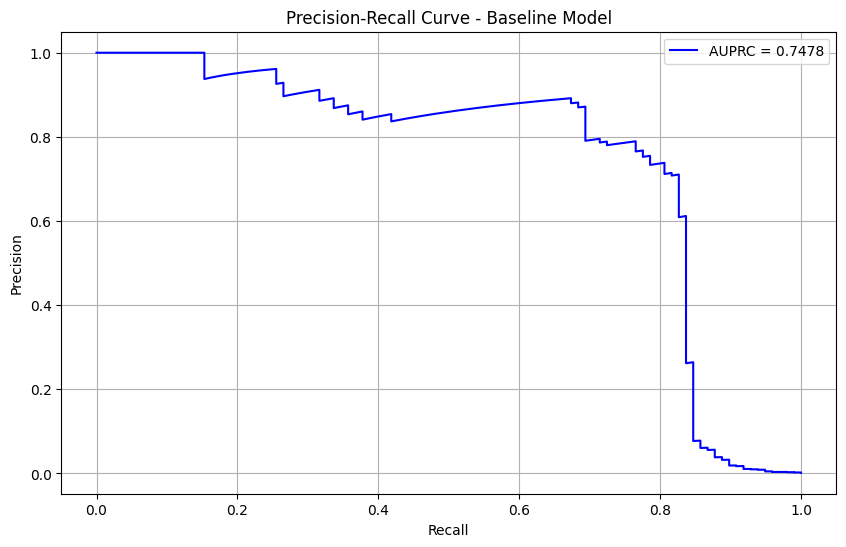

In [93]:
# Prepare data for modeling
X = df.drop('Class', axis=1)
y = df['Class']

# Initialize stratified k-fold cross validation
# The critical part is that you do set a random_state to a fixed integer when you
# want your code to produce the same results across multiple runs.
# If you don't set a random_state (or set it to None)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize logistic regression as baseline model
lr_model = LogisticRegression(random_state=42)

# Lists to store precision, recall and AUPRC scores
precision_scores = []
recall_scores = []
auprc_scores = []

# Perform cross validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    # Split data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Train model
    lr_model.fit(X_train, y_train)
    
    # Get predictions
    y_pred_proba = lr_model.predict_proba(X_val)[:, 1]
    
    # Calculate metrics
    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
    auprc = average_precision_score(y_val, y_pred_proba)
    
    auprc_scores.append(auprc)
    
    print(f'Fold {fold + 1} - AUPRC: {auprc:.4f}')

print('\nMean AUPRC: {:.4f} (+/- {:.4f})'.format(
    np.mean(auprc_scores), 
    np.std(auprc_scores) * 2
))

# Plot Precision-Recall curve for the last fold
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', label=f'AUPRC = {auprc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Baseline Model')
plt.legend()
plt.grid(True)
plt.show()


In [94]:
# Example of making predictions with a threshold of 0.8
# Let's simulate some new transaction data (using the same features as training data)
new_transaction = X.iloc[0:1]  # Using first row as example new transaction
print(f"fraud: {y.iloc[0:1].values}")

# Get probability predictions 
# Get probability predictions from logistic regression model
# predict_proba returns probabilities for both classes [P(class=0), P(class=1)]
# We take [:, 1] to get only the probability of fraud (class 1)
pred_proba = lr_model.predict_proba(new_transaction)[:, 1]  # Returns probability of fraud between 0 and 1
print(pred_proba)

# Apply threshold of 0.8
threshold = 0.8
prediction = (pred_proba >= threshold).astype(int)

print("Probability of fraud:", pred_proba[0])
print(f"Prediction (threshold={threshold}):", prediction[0])
print("Actual prediction would be fraud" if prediction[0] == 1 else "Actual prediction would be legitimate")


fraud: [0]
[0.00074321]
Probability of fraud: 0.0007432110466253791
Prediction (threshold=0.8): 0
Actual prediction would be legitimate


### Random undersampling technique

- we need to also create a sub sample of the dataframe in order to have an equal amount of Fraud and
Non-Fraud cases, helping our algorithms better understand patterns that determines whether a transaction
is a fraud or not.

- What is a sub-Sample?
In this scenario, our subsample will be a dataframe with a 50/50 ratio of fraud and non-fraud transactions. Meaning our sub-sample will have the same amount of fraud and non fraud transactions.

- What happens if a sub-sample (or another technique) is not used?
    - Overfitting: Our classification models will assume that in most cases there are no frauds! What we want for our model is to be certain when a fraud occurs.
    -Wrong Correlations: Although we don't know what the "V" features stand for, it will be useful to understand how each of this features influence the result (Fraud or No Fraud) by having an imbalance dataframe we are not able to see the true correlations between the class and features.

- Random undersampling. There are 492 cases of fraud in our dataset so we can randomly get 492 cases of non-fraud to create our new sub dataframe. We concat the 492 cases of fraud and non fraud, creating a new sub-sample.

In [96]:
fraud_cases = df[(df.Class==1)].shape[0]
print(f"fraud cases: {fraud_cases}")


fraud cases: 492
